# Finetune T5 for Summarization

## Benchmark T5 and BART for CNN/DM dataset

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from datasets import load_dataset

dataset = load_dataset("cnn_dailymail", '3.0.0', split="train[:10]")

In [4]:
print("Article:")
print(dataset[0]['article'])
print("\nSummary:")
print(dataset[0]['highlights'])

Article:
LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don't think I'll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office chart. Detai

In [5]:
input = dataset[0]['article']

In [6]:
import torch
from transformers import pipeline

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [7]:
summary = {}

pipe = pipeline("summarization", model="flax-community/t5-base-cnn-dm")
output = pipe(input)
summary['t5-base'] = output[0]['summary_text']

pipe = pipeline("summarization", model="ainize/bart-base-cnn")
output = pipe(input)
summary['bart-large'] = output[0]['summary_text']

Device set to use cuda:0
Token indices sequence length is longer than the specified maximum sequence length for this model (638 > 512). Running this sequence through the model will result in indexing errors
Device set to use cuda:0


In [8]:
for model in summary:
    print(f"Model: {model}")
    print(f"Summary: {summary[model]}\n")

Model: t5-base
Summary: Harry Potter star Daniel Radcliffe gets £20 million ($41.1 million) fortune as he turns 18 Monday . The young actor says he has no plans to fritter his cash away on celebrity parties . His earnings from the first five Potter films have been held in a trust fund .

Model: bart-large
Summary: Daniel Radcliffe gains access to reported £20 million fortune as he turns 18 .
Young actor says he has no plans to fritter his cash away on fast cars, drink .
Details of how he'll mark landmark birthday are under wraps .
Radcliffe's earnings from first five Potter films have been held in trust fund .



T5 produces shorter summary but still keeps the important things and more coherent than BART.

## T5 for Dialogue Summarization

### Import dataset

In [9]:
samsum = load_dataset("knkarthick/samsum", trust_remote_code=True)

In [10]:
samsum

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
})

In [11]:
samsum['train'][1]

{'id': '13728867',
 'dialogue': 'Olivia: Who are you voting for in this election? \nOliver: Liberals as always.\nOlivia: Me too!!\nOliver: Great',
 'summary': 'Olivia and Olivier are voting for liberals in this election. '}

### Dataset analysis

In [12]:
# Check words length in dialogue and summary
dialogue_len = [len(x['dialogue'].split()) for x in samsum['train'] if x['dialogue'] is not None]
summary_len = [len(x['summary'].split()) for x in samsum['train'] if x['summary'] is not None]

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

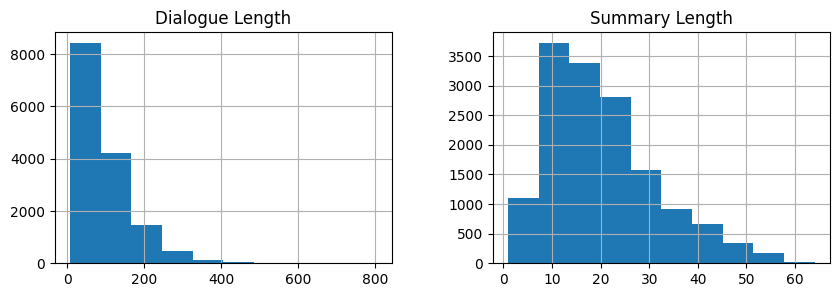

In [14]:
temp_data = pd.DataFrame([dialogue_len, summary_len]).T
temp_data.columns = ["Dialogue Length", "Summary Length"]

temp_data.hist(figsize=(10,3))
plt.show()

We will set the maximum input length around 200 because most of the data is around 200 words.

### Load model and tokenizer

In [15]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

In [16]:
model_ckpt = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

In [17]:
samsum['train'][0]

{'id': '13818513',
 'dialogue': "Amanda: I baked  cookies. Do you want some?\nJerry: Sure!\nAmanda: I'll bring you tomorrow :-)",
 'summary': 'Amanda baked cookies and will bring Jerry some tomorrow.'}

In [18]:
tokenizer(samsum['train'][0]['dialogue'],
         text_target=samsum['train'][0]['summary'], 
         return_tensors='pt')

{'input_ids': tensor([[21542,    10,    27, 13635,  5081,     5,   531,    25,   241,   128,
            58, 16637,    10, 10625,    55, 21542,    10,    27,    31,   195,
           830,    25,  5721,     3,    10,    18,    61,     1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]]), 'labels': tensor([[21542, 13635,  5081,    11,    56,   830, 16637,   128,  5721,     5,
             1]])}

### Remove null values on dataset
Previously the train process encounter an error because the dataset contains null data, so it should be dropped.

In [19]:
samsum

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
})

In [20]:
df_train = pd.DataFrame(samsum['train']).dropna()
df_validation = pd.DataFrame(samsum['validation']).dropna()
df_test = pd.DataFrame(samsum['test']).dropna()

In [21]:
from datasets import Dataset, DatasetDict

In [22]:
samsum = DatasetDict(
    {
        'train': Dataset.from_pandas(df_train, preserve_index=False),
        'validation': Dataset.from_pandas(df_validation, preserve_index=False),
        'test': Dataset.from_pandas(df_test, preserve_index=False)
    }
)

samsum

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14731
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
})

### Tokenization

In [23]:
def tokenize(batch):
    output = tokenizer(batch['dialogue'], 
                       text_target=batch['summary'],
                       max_length=200,
                       padding=True,
                       truncation=True,
                       return_tensors='pt')
    return output

In [24]:
samsum_pt = samsum.map(tokenize, batched=True, batch_size=None)

Map: 100%|██████████| 819/819 [00:00<00:00, 2399.99 examples/s]


### Data collation

In [25]:
from transformers import DataCollatorForSeq2Seq

In [26]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

### Train the model

In [27]:
from transformers import TrainingArguments

In [28]:
batch_size = 32
training_dir = "train_dir"

training_args = TrainingArguments(
    output_dir=training_dir,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    eval_strategy='epoch',
    seed=42,
    gradient_accumulation_steps=500
)

In [29]:
from transformers import Trainer

In [30]:
trainer = Trainer(model=model, 
                  args=training_args, 
                  data_collator=data_collator,
                  train_dataset=samsum_pt['train'], 
                  eval_dataset=samsum_pt['validation'], 
                  tokenizer=tokenizer,    
                 )

In [31]:
trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,No log,16.888424
2,No log,16.608576


TrainOutput(global_step=2, training_loss=14.438966751098633, metrics={'train_runtime': 174.4296, 'train_samples_per_second': 168.905, 'train_steps_per_second': 0.011, 'total_flos': 1557593810534400.0, 'train_loss': 14.438966751098633, 'epoch': 2.0})

We can add metrics like ROUGE or BLEU but in this notebook we only use validation loss.

In [32]:
trainer.save_model("./models/t5_summarization")

### Predict on another data

In [33]:
from transformers import pipeline

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [34]:
input = samsum['test'][100]['dialogue']
pipe = pipeline('summarization', model="./models/t5_summarization", device=device)

output = pipe(input)

Device set to use cuda


In [35]:
input

"Chris: Hi there! Where are you? Any chance of skyping?\nRick: Hi! Our last two days in Cancun before flying to Havana. Yeah, skyping is an idea. When would it suit you?\nRick: We don't have the best of connections in the room but I can get you pretty well in the lobby.\nChris: What's the time in your place now?\nRick: 6:45 pm\nChris: It's a quarter to one in the morning here. Am still in front of the box.\nRick: Gracious me! Sorry mate. You needn't have answered.\nChris: 8-D\nRick: Just tell me when we could skype.\nChris: Preferably in the evening. Just a few hours earlier than now. And not tomorrow.\nRick: Shute! Only tomorrow makes sense as there's no workable internet in Cuba.\nChris: Could you make it like 3 pm your time?\nRick: Sure.\nChris: Perfect. So talk to you tomorrow.\nChris: Give my love to Helen please.\nRick: I will. Thx."

In [36]:
output

[{'summary_text': "Chris: I can get you pretty well in the lobby . Chris: a quarter to one in the morning here. You needn't have answered ."}]